In [2]:
# hide
%reload_ext autoreload
%autoreload 2

In [3]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from dataFunction import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from run_simulations import run_simulations
from datetime import datetime
import json
random.seed(11007303)
np.random.seed(2021)

/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_FL_Ectrie/thesis_fl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [5]:
cleveland = "FL_HE_2/processed.cleveland.data"
switzerland = "FL_HE_2/processed.switzerland.data"
va = "FL_HE_2/processed.va.data"
hungarian = "FL_HE_2/reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)


In [6]:
def average_state_dict_test(state_dicts, len_dict, keys):
    result = {}
    # result = copy.deepcopy(state_dicts[0])
    for i, state_dict in enumerate(state_dicts):
        for key in keys:
            if i == 0:
                result[key] =  state_dict[key]*(len_dict[i]/sum(len_dict))
            else:
                result[key] += state_dict[key]*(len_dict[i]/sum(len_dict))
    return result

In [7]:
def FL_proces_test(clients, validation_X_set, validation_y_set, ctx_eval, glob_model, iters, simulation= False, switzerland= False):
    loss_train = []
    net_best = None
    best_acc = None
    best_epoch = None
    results = []
    min_loss_client = []
    glob_model.eval()
    if switzerland:
        client_results = {
            'Cleveland': [],
            'Switzerland': [],
            'VA Long Beach': [],
            'Hungary': []
        }
    else:
        client_results = {
            'Cleveland': [],
            'VA Long Beach': [],
            'Hungary': []
            }
    enrypted_state_dicts= None
    acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set, simulation)

    best_acc = acc_test
    for iter in range(iters):
        loss_locals = []
        client_state_dicts = []
        client_len = []
        for client in clients:
            client_model = copy.deepcopy(glob_model)
            client.set_state_dict(client_model.state_dict())
            client_state_dict, loss = train_model_client(client, epochs=40, simulation = simulation)
            
            loss_locals.append(copy.deepcopy(loss))
            min_loss_client.append(min(loss))
            client_acc, client_loss = accuracy_loss_LR(client.model, client.X_test, client.y_test)
            new_list = client_results.get(client.name)
            new_list.append(client_acc)
            client_results[client.name] = new_list
            client_state_dicts.append(client_state_dict)
            client_len.append(len(client.y))

        enrypted_state_dicts = encrypt_state_dicts(copy.deepcopy(client_state_dicts), ctx_eval)
        averaged_encrypted_state_dict = average_state_dict_test(enrypted_state_dicts, client_len, [k for k in enrypted_state_dicts[0]])
        decrypted_state_dicts = decrypt_state_dicts(averaged_encrypted_state_dict)
        glob_model.load_state_dict(decrypted_state_dicts)

        loss_avg = sum(min_loss_client) / len(min_loss_client)
        loss_train.append(loss_avg)        
            
        acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set, simulation)

        # print('Round {:3d}, Average loss {:.3f}, Test loss {:.3f}, Test accuracy: {:.2f}'.format(
        #     iter, loss_avg, loss_test, acc_test))


        if best_acc is None or acc_test > best_acc:
            net_best = copy.deepcopy(glob_model)
            best_acc = acc_test
            best_epoch = iter

        results.append(np.array([iter, loss_avg, loss_test, acc_test, best_acc]))
        final_results = np.array(results)
        final_results = pd.DataFrame(final_results, columns=['epoch', 'loss_avg', 'loss_test', 'acc_test', 'best_acc'])

    # print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))    
    return best_epoch, best_acc, glob_model.state_dict(), final_results, client_results

In [14]:
df_dict_W ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_W = []

for i in list(df_dict_W.keys()):
    df = df_dict_W.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_W = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_W)
    lr = 0.1
    clients_W.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_W = KL_matrices_disc_cont(clients_W, cat_bin_features, numeric_feature_names)
KL_mean_W = (np.array(KL_W)[np.triu_indices(len(clients_W), k=1)].mean() + np.array(KL_W)[np.tril_indices(len(clients_W), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_W:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model = LR(len(clients_W[0].X.columns))
val_x_W, val_y_W = make_validation_sets(clients_W)

best_epoch_W, best_acc_W, model_dict_W, final_results_W, client_results_W = FL_proces_test(clients_W, val_x_W, val_y_W, ctx_eval, glob_model_W, 10000, False, False)
print(df_dict_W.keys())
print(clients_W[0].X.columns)
print(KL_W)
print('KL FL mean: {}'.format(KL_mean_W))
print('Best model, iter: {}, acc: {}'.format(best_epoch_W, best_acc_W))  
for i in list(client_results_W.keys()):
    list_client = client_results_W.get(i)
    print('{} has accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.195766  2.491469
1  2.578414  0.000000  2.326614
2  1.561995  1.988351  0.000000
KL FL mean: 2.190434912504877
Best model, iter: 845, acc: 0.7933333516120911
Cleveland has accuracy 0.5369442105293274
Cleveland has max accuracy 0.8360655903816223
Cleveland has min accuracy 0.16393442451953888
VA Long Beach has accuracy 0.5302866697311401
VA Long Beach has max accuracy 0.8666666746139526
VA Long Beach has min accuracy 0.13333334028720856
Hungary has accuracy 0.5483084321022034
Hungary has max accuracy 0.9152542352676392
Hungary has min accuracy 0.11864406615495682


In [15]:
df_dict_SW ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_SW = []

for i in list(df_dict_SW.keys()):
    df = df_dict_SW.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_SW = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_SW:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_SW = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_SW)
    lr = 0.1
    clients_SW.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_SW = KL_matrices_disc_cont(clients_SW, cat_bin_features, numeric_feature_names_SW)
KL_mean_S = (np.array(KL_SW)[np.triu_indices(len(clients_SW), k=1)].mean() + np.array(KL_SW)[np.tril_indices(len(clients_SW), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_SW:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model_S = LR(len(clients_SW[0].X.columns))
val_x_SW, val_y_SW = make_validation_sets(clients_SW)

best_epoch_SW, best_acc_SW, model_dict_SW, final_results_SW, client_results_SW = FL_proces_test(clients_SW, val_x_SW, val_y_SW, ctx_eval, glob_model_SW, 10000, False, True)
print(df_dict_SW.keys())
print(clients_SW[0].X.columns)
print(KL_SW)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_SW, best_acc_SW))  
for i in list(client_results_SW.keys()):
    list_client = client_results_SW.get(i)
    print('{} has accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))


dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'FastingBS', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ChestPainType_1', 'ChestPainType_4', 'ChestPainType_3',
       'ChestPainType_2', 'RestingECG_2', 'RestingECG_0', 'RestingECG_1',
       'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2         3
0  0.000000  1.735963  2.183113  2.466082
1  1.591768  0.000000  0.709178  1.352810
2  2.558419  0.878337  0.000000  2.320192
3  1.539079  1.345990  1.981744  0.000000
KL FL mean: 1.7218895712985067
Best model, iter: 14, acc: 0.7599999904632568
Cleveland has accuracy 0.5243065357208252
Cleveland has max accuracy 0.868852436542511
Cleveland has min accuracy 0.13114753365516663
Switzerland has accuracy 0.5081599354743958
Switzerland has max accuracy 0.9599999785423279
Switzerland has min accuracy 0.0
VA Long Beach has accuracy 0.5172533392906189
VA Long Beach has max accuracy 0.866666674613

In [16]:
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model)
    lr = 0.1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL = KL_matrices_disc_cont(clients, cat_bin_features, numeric_feature_names)
KL_mean = (np.array(KL)[np.triu_indices(len(clients), k=1)].mean() + np.array(KL)[np.tril_indices(len(clients), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model = LR(len(clients[0].X.columns))
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results , client_results = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 10000, False, False)
print(df_dict.keys())
print(clients[0].X.columns)
print(KL)
print('KL FL mean: {}'.format(KL_mean))
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  
for i in list(client_results.keys()):
    list_client = client_results.get(i)
    print('{} has accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))


In [ ]:
df_dict_S ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_S = []

for i in list(df_dict_S.keys()):
    df = df_dict_S.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_S = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_S:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    # print(y.value_counts())
    glob_model_S = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_S)
    lr = 0.1
    clients_S.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_S = KL_matrices_disc_cont(clients_S, cat_bin_features, numeric_feature_names_S)
KL_mean_S = (np.array(KL_S)[np.triu_indices(len(clients_S), k=1)].mean() + np.array(KL_S)[np.tril_indices(len(clients_S), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_S:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model_S = LR(len(clients_S[0].X.columns))
val_x_S, val_y_S = make_validation_sets(clients_S)

best_epoch_S, best_acc_S, model_dict_S, final_results_S, client_results_S = FL_proces(clients_S, val_x_S, val_y_S, ctx_eval, glob_model_S, 10000, False, True)
print(df_dict_S.keys())
print(clients_S[0].X.columns)
print(KL_S)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_S, best_acc_S))  
for i in list(client_results_S.keys()):
    list_client = client_results_S.get(i)
    print('{} has mean accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))



dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0             1         2         3
0  0.000000  1.748567e+00  2.183113  2.466082
1  1.595784 -2.220446e-16  0.706801  1.348535
2  2.558419  8.792501e-01  0.000000  2.320192
3  1.539079  1.348049e+00  1.981744  0.000000
KL FL mean: 1.7229679340099695
Best model, iter: 67, acc: 0.5657142996788025
Cleveland has accuracy 0.524590015411377
Switzerland has accuracy 0.8399999141693115
VA Long Beach has accuracy 0.8646667003631592
Hungary has accuracy 0.32203391194343567


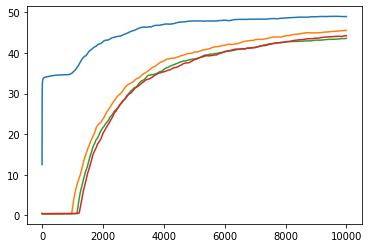

In [76]:
plt.plot(final_results_S.best_acc)
plt.plot(final_results.best_acc)
plt.plot(final_results_SW.best_acc)
plt.plot(final_results_W.best_acc)
# plt.plot(final_results_S.loss_test)
# plt.plot(final_results.loss_test)
# plt.plot(final_results_SW.loss_test)
# plt.plot(final_results_W.loss_test)
plt.show()

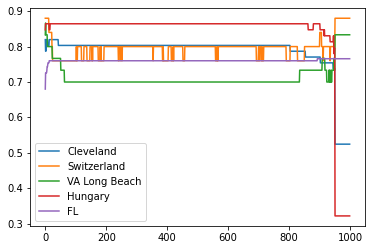

In [ ]:
for i in list(client_results_SW.keys()):
    list_client = client_results_SW.get(i)
    plt.plot(list_client[0:best_epoch_SW+1], label = i)
plt.plot(final_results_SW.best_acc[0:best_epoch_SW+1], label ='FL')
plt.legend()

In [ ]:
client_results_W.keys()

dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])

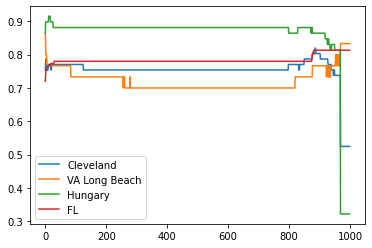

In [ ]:
for i in list(client_results_W.keys()):
    list_client = client_results_W.get(i)
    plt.plot(list_client[0:best_epoch_W+1], label = i)
plt.plot(final_results_W.best_acc[0:best_epoch_W+1], label ='FL')
plt.legend()

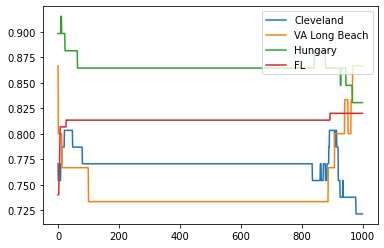

In [ ]:
for i in list(client_results.keys()):
    list_client = client_results.get(i)
    plt.plot(list_client[0:best_epoch+1], label = i)
plt.plot(final_results.best_acc[0:best_epoch+1], label ='FL')
plt.legend()

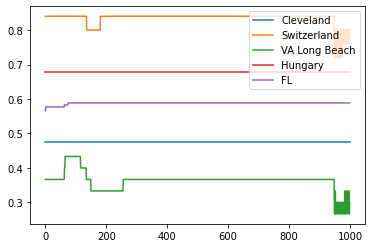

In [ ]:
for i in list(client_results_S.keys()):
    list_client = client_results_S.get(i)
    plt.plot(list_client[0:best_epoch_S+1], label = i)
plt.plot(final_results_S.best_acc[0:best_epoch_S+1], label ='FL')
plt.legend()

In [1]:
pd.DataFrame(client_results_S).describe

NameError: name 'pd' is not defined

In [112]:
list_client

[tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220),
 tensor(0.3220

In [163]:
kl = np.empty(((len(clients_S)+1), (len(clients_S)+1)))
for i in range(len(clients_S)+1):
    for j in range(len(clients_S)+1):
        # print(j)
        if i > len(clients_S)-1 and j >  len(clients_S)-1:
             kl[i,j] = KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(val_y_S))
        elif i > len(clients_S)-1:
            # print(j)
            kl[i,j] = KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[j].y))
        elif j > len(clients_S)-1:
            kl[i,j] = KL_divergence_disc(prob_discrete_var(clients_S[i].y),prob_discrete_var(val_y_S))
        else:
            # print(i)
            kl[i,j] = KL_divergence_disc(prob_discrete_var(clients_S[i].y),prob_discrete_var(clients_S[j].y))
        
kl

array([[0.        , 0.81606373, 0.24531176, 0.01974054, 0.02060895],
       [0.5263773 , 0.        , 0.08868103, 0.73747312, 0.35359624],
       [0.21714275, 0.12425976, 0.        , 0.36644708, 0.10681021],
       [0.01926872, 1.10899946, 0.40381697, 0.        , 0.07930172],
       [0.02055637, 0.55086584, 0.12048189, 0.08102912, 0.        ]])

In [148]:
print(KL_divergence_disc(prob_discrete_var(clients_S[0].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(clients_S[1].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(clients_S[2].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(clients_S[3].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[0].y)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[1].y)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[2].y)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[3].y)))

0.020608951084511343
0.35359623662580264
0.10681021480970254
0.07930172225104493
0.020556374461161667
0.5508658350408384
0.12048189312316646
0.08102912464591883


In [147]:
clients_S

In [138]:
glob_model_S = LR(val_x_S.shape[1])
clients_S.append(Client('Validation', val_x_S, val_y_S,glob_model, 0.1, torch.nn.BCELoss(reduction='mean'), None))
# clients.append(Client(i, x, y, client_model, lr,  torch.nn.BCELoss(reduction='mean'), weights) )

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [19]:
kl = np.empty((len(clients_SW), len(clients_SW)))
for i in range(len(clients_SW)):
    for j in range(len(clients_SW)):
        kl[i,j] = KL_divergence_disc(prob_discrete_var(clients_SW[i].y),prob_discrete_var(clients_SW[j].y))
kl

array([[0.        , 0.81187507, 0.24531176, 0.01974054],
       [0.52485028, 0.        , 0.08793214, 0.73572809],
       [0.21714275, 0.1229088 , 0.        , 0.36644708],
       [0.01926872, 1.10395643, 0.40381697, 0.        ]])

In [46]:
datanames = ['cleveland', 'switzerland',' va_long', 'hungary']
for i in range(len(clients_SW)):
    for j in range(len(clients_SW)):
        if  i < j:
            print(datanames[i],datanames[j])
            print((kl[i,j]+kl[j,i])/2)
            print((kl_s[i,j]+kl_s[j,i])/2)

cleveland switzerland
0.6712205144505923
1.6721754287886084
cleveland  va_long
0.23122725500731667
2.37076571303971
cleveland hungary
0.019504629104145965
2.00258054248156
switzerland  va_long
0.10647039557669041
0.793025779565288
switzerland hungary
0.9232362923262525
1.3482923622663496
 va_long hungary
0.3851320241364045
2.150967777918301


In [45]:
kl_s = KL_S.to_numpy()

In [34]:
(2.196+2.578)/2 #CV

2.387

In [35]:
(2.327+1.988)/2 # HV

2.1574999999999998

In [25]:
np.mean(kl,axis=1)

array([0.27027901, 0.33813286, 0.1769624 , 0.38302129])

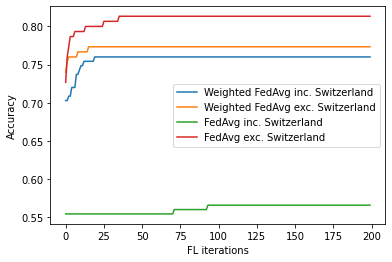

In [32]:
plt.plot(final_results_SW.best_acc[:200], label= 'Weighted FedAvg inc. Switzerland')
plt.plot(final_results_W.best_acc[:200], label= 'Weighted FedAvg exc. Switzerland')
plt.plot(final_results_S.best_acc[:200], label= 'FedAvg inc. Switzerland')
plt.plot(final_results.best_acc[:200], label= 'FedAvg exc. Switzerland')
plt.ylabel('Accuracy')
plt.xlabel('FL iterations')
plt.legend()

# plt.savefig('images/Accuracy_Healthcare_iter2000',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/Accuracy_Healthcare_iter2000', bbox_inches='tight',  dpi=300)
plt.show()

In [ ]:
plt.plot(final_results_SW.best_acc[:2000], label= 'Weighted FedAvg inc. Switzerland')
plt.plot(final_results_W.best_acc[:2000], label= 'Weighted FedAvg exc. Switzerland')
plt.plot(final_results_S.best_acc[:2000], label= 'FedAvg inc. Switzerland')
plt.plot(final_results.best_acc[:2000], label= 'FedAvg exc. Switzerland')
plt.ylabel('Accuracy')
plt.xlabel('FL iterations')
plt.legend()

# plt.savefig('images/Accuracy_Healthcare',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/Accuracy_Healthcare', bbox_inches='tight',  dpi=300)
plt.show()

In [17]:
model_acc = {'FedAvg Inc. Switzerland':float( best_acc_S.numpy()),
   'FedAvg Exc. Switzerland': float(best_acc.numpy()),
    'Weighted FedAvg Inc. Switzerland': float(best_acc_SW.numpy()),
    'Weighted FedAvg Exc. Switzerland': float(best_acc_W.numpy())
}

time_str = str(datetime.now())
with open('Results/heartdata_'+time_str+'.json', 'w') as convert_file:
     convert_file.write(json.dumps(model_acc))

In [18]:
# color_map = ["#238b45",
# "#66c2a4",
# "#fb6a4a",
# "#cb181d"]
# from matplotlib import ticker
# color_map = [
# "#e41a1c",
# "#377eb8",
# "#4daf4a",
# "#984ea3"
# ]



# plt.barh( model_acc, models,color=color_map)

# x_pos = [0,10, 20,30]
# plt.xticks(x_pos, models)



# plt.savefig('../images/Accuracy_Healthcare_c',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/Romy/Documents/Master Thesis/Thesis_latex/images/Accuracy_Healthcare_c', bbox_inches='tight',  dpi=300)
# plt.show()

In [12]:
float( best_acc_S.numpy())

0.6571428775787354

In [243]:
# Plot predicted vs test!

# import plotly.graph_objects as go
# net_best_S.load_state_dict(model_dict_S)
y_pred = net_best(val_x).detach().numpy()
y_test = val_y

y_pred_round =y_pred.round()

fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred_round[:,0],
                    mode='markers',
                    name='Pred'))